A financial institution is evaluating machine learning technologies for optical character recognition. The following testing has been conducted to explore what type of neural network typology and hyperparameter settings could be recommended to the financial instituition. Initial testing is on the MNIST digits dataset. 

In [1]:
# code from 3_mnist_from_scratch-data-dump.py
# Import MNIST data

import os
from six.moves.urllib.request import urlretrieve

SOURCE_URL = 'https://storage.googleapis.com/cvdf-datasets/mnist/'
WORK_DIRECTORY = "C:/Users/MCJ/Documents/Northwestern/422 - Machine Learning/Assignment \
                  6/jump-start-mnist-scikit-learn-ann"

def maybe_download(filename):
    """A helper to download the data files if not present."""
    if not os.path.exists(WORK_DIRECTORY):
        os.mkdir(WORK_DIRECTORY)
    filepath = os.path.join(WORK_DIRECTORY, filename)
    if not os.path.exists(filepath):
        filepath, _ = urlretrieve(SOURCE_URL + filename, filepath)
        statinfo = os.stat(filepath)
        print('Successfully downloaded', filename, statinfo.st_size, 'bytes.')
    else:
        print('Already downloaded', filename)
    return filepath

train_data_filename = maybe_download('train-images-idx3-ubyte.gz')
train_labels_filename = maybe_download('train-labels-idx1-ubyte.gz')
test_data_filename = maybe_download('t10k-images-idx3-ubyte.gz')
test_labels_filename = maybe_download('t10k-labels-idx1-ubyte.gz')

Already downloaded train-images-idx3-ubyte.gz
Already downloaded train-labels-idx1-ubyte.gz
Already downloaded t10k-images-idx3-ubyte.gz
Already downloaded t10k-labels-idx1-ubyte.gz


In [2]:
# Pre-processing:
# Decompress the gzipped data
# Normalize these to [-0.5, 0.5].
# Ensure data is read properly by reading first image from test data 

import gzip, binascii, struct, numpy
import matplotlib.pyplot as plt

with gzip.open(test_data_filename) as f:
    # Print the header fields.
    for field in ['magic number', 'image count', 'rows', 'columns']:
        # struct.unpack reads the binary data provided by f.read.
        # The format string '>i' decodes a big-endian integer, which
        # is the encoding of the data.
        print(field, struct.unpack('>i', f.read(4))[0])
    
    # Read the first 28x28 set of pixel values. 
    # Each pixel is one byte, [0, 255], a uint8.
    buf = f.read(28 * 28)
    image = numpy.frombuffer(buf, dtype=numpy.uint8)
  
    # Print the first few values of image.
    print('First 10 pixels:', image[:10])

magic number 2051
image count 10000
rows 28
columns 28
First 10 pixels: [0 0 0 0 0 0 0 0 0 0]


magic number 2051
image count 10000
rows 28
columns 28
First 10 pixels: [0 0 0 0 0 0 0 0 0 0]


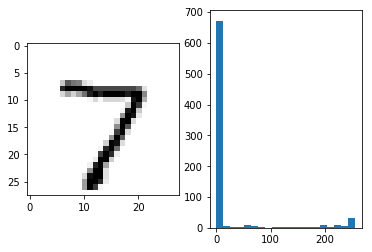

In [3]:
# Decompress the gzipped data
# Normalize data to [-0.5, 0.5].
# Ensure data is read properly by reading first image from test data 

import gzip, binascii, struct, numpy
import matplotlib.pyplot as plt

with gzip.open(test_data_filename) as f:
    # Print the header fields.
    for field in ['magic number', 'image count', 'rows', 'columns']:
        # struct.unpack reads the binary data provided by f.read.
        # The format string '>i' decodes a big-endian integer, which
        # is the encoding of the data.
        print(field, struct.unpack('>i', f.read(4))[0])
    
    # Read the first 28x28 set of pixel values. 
    # Each pixel is one byte, [0, 255], a uint8.
    buf = f.read(28 * 28)
    image = numpy.frombuffer(buf, dtype=numpy.uint8)
 
  # Print the first few values of image.
    print('First 10 pixels:', image[:10])
    
get_ipython().magic(u'matplotlib inline')

# We'll show the image and its pixel value histogram side-by-side.
_, (ax1, ax2) = plt.subplots(1, 2)

# To interpret the values as a 28x28 image, we need to reshape
# the numpy array, which is one dimensional.
ax1.imshow(image.reshape(28, 28), cmap=plt.cm.Greys);

ax2.hist(image, bins=20, range=[0,255]); 

The output looks like the data is being brought in correctly as the image appears to be a seven and the histogram is indicating a lot of white(0), some black (255) and grayscale as everything in between. 

In [ ]:
# Normalization
# convert the uint8 image to 32 bit floats and 
# rescale the values to be centered around 0, between [-0.5, 0.5]. 
scaled = image.astype(numpy.float32)
scaled = (scaled - (255 / 2.0)) / 255
_, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(scaled.reshape(28, 28), cmap=plt.cm.Greys);
ax2.hist(scaled, bins=20, range=[-0.5, 0.5]);

Ran cell, but deleted results to save space.

In [5]:
# unpack the test label data and ensure it is correct, expecting a 7
with gzip.open(test_labels_filename) as f:
    # Print the header fields.
    for field in ['magic number', 'label count']:
        print(field, struct.unpack('>i', f.read(4))[0])

    print('First label:', struct.unpack('B', f.read(1))[0])

magic number 2049
label count 10000
First label: 7


In [6]:
# Create training and testing data sets

IMAGE_SIZE = 28
PIXEL_DEPTH = 255

def extract_data(filename, num_images):
    """Extract the images into a 4D tensor [image index, y, x, channels].
  
    For MNIST data, the number of channels is always 1.

    Values are rescaled from [0, 255] down to [-0.5, 0.5].
    """
    print('Extracting', filename)
    with gzip.open(filename) as bytestream:
        bytestream.read(16)

        buf = bytestream.read(IMAGE_SIZE * IMAGE_SIZE * num_images)
        data = numpy.frombuffer(buf, dtype=numpy.uint8).astype(numpy.float32)
        data = (data - (PIXEL_DEPTH / 2.0)) / PIXEL_DEPTH
        data = data.reshape(num_images, IMAGE_SIZE, IMAGE_SIZE, 1)
        return data

train_data = extract_data(train_data_filename, 60000)
test_data = extract_data(test_data_filename, 10000)

Extracting C:/Users/MCJ/Documents/Northwestern/422 - Machine Learning/Assignment 6/jump-start-mnist-scikit-learn-ann\train-images-idx3-ubyte.gz
Extracting C:/Users/MCJ/Documents/Northwestern/422 - Machine Learning/Assignment 6/jump-start-mnist-scikit-learn-ann\t10k-images-idx3-ubyte.gz


In [ ]:
# Ensure reshaping parameters are correct by
# examing the dimensions and the first two images.

print('Training data shape', train_data.shape)
_, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(train_data[0].reshape(28, 28), cmap=plt.cm.Greys);
ax2.imshow(train_data[1].reshape(28, 28), cmap=plt.cm.Greys);

Ran cell, but deleted results to save space.

In [8]:
# Load full set of labels. 
# Convert input labels into a 1-hot encoding for digits 0-9

NUM_LABELS = 10

def extract_labels(filename, num_images):
    """Extract the labels into a 1-hot matrix [image index, label index]."""
    print('Extracting', filename)
    with gzip.open(filename) as bytestream:
        # Skip the magic number and count; we know these values.
        bytestream.read(8)
        buf = bytestream.read(1 * num_images)
        labels = numpy.frombuffer(buf, dtype=numpy.uint8)
    # Convert to dense 1-hot representation.
    return (numpy.arange(NUM_LABELS) == labels[:, None]).astype(numpy.float32)

train_labels = extract_labels(train_labels_filename, 60000)
test_labels = extract_labels(test_labels_filename, 10000)

# Ensure 1-hot encoding looks accurate
print('Training labels shape', train_labels.shape)
print('First label vector', train_labels[0])
print('Second label vector', train_labels[1])

Extracting C:/Users/MCJ/Documents/Northwestern/422 - Machine Learning/Assignment 6/jump-start-mnist-scikit-learn-ann\train-labels-idx1-ubyte.gz
Extracting C:/Users/MCJ/Documents/Northwestern/422 - Machine Learning/Assignment 6/jump-start-mnist-scikit-learn-ann\t10k-labels-idx1-ubyte.gz
Training labels shape (60000, 10)
First label vector [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
Second label vector [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [9]:
# Create validation dataset from training set

VALIDATION_SIZE = 5000

validation_data = train_data[:VALIDATION_SIZE, :, :, :]
validation_labels = train_labels[:VALIDATION_SIZE]
train_data = train_data[VALIDATION_SIZE:, :, :, :]
train_labels = train_labels[VALIDATION_SIZE:]

train_size = train_labels.shape[0]

print('Validation shape', validation_data.shape)
print('Train size', train_size)

Validation shape (5000, 28, 28, 1)
Train size 55000


In [10]:
# code from 3_mnist_from_scratch.py

import tensorflow as tf

# bundle groups of examples during training for efficiency
BATCH_SIZE = 60
NUM_CHANNELS = 1
SEED = 42

# Where training samples and labels are fed to the graph.
train_data_node = tf.placeholder(
  tf.float32,
  shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS))
train_labels_node = tf.placeholder(tf.float32,
                                   shape=(BATCH_SIZE, NUM_LABELS))

# For the validation and test data, the entire dataset will be 
# in one constant node.
validation_data_node = tf.constant(validation_data)
test_data_node = tf.constant(test_data)

# The variables below hold all the trainable weights. For each, the
# parameter defines how the variables will be initialized.
conv1_weights = tf.Variable(
  tf.truncated_normal([5, 5, NUM_CHANNELS, 32],  # 5x5 filter, depth 32.
                      stddev=0.1,
                      seed=SEED))
conv1_biases = tf.Variable(tf.zeros([32]))
conv2_weights = tf.Variable(
  tf.truncated_normal([5, 5, 32, 64],
                      stddev=0.1,
                      seed=SEED))
conv2_biases = tf.Variable(tf.constant(0.1, shape=[64]))
fc1_weights = tf.Variable(  # fully connected, depth 512.
  tf.truncated_normal([IMAGE_SIZE // 4 * IMAGE_SIZE // 4 * 64, 512],
                      stddev=0.1,
                      seed=SEED))
fc1_biases = tf.Variable(tf.constant(0.1, shape=[512]))
fc2_weights = tf.Variable(
  tf.truncated_normal([512, NUM_LABELS],
                      stddev=0.1,
                      seed=SEED))
fc2_biases = tf.Variable(tf.constant(0.1, shape=[NUM_LABELS]))

print('Done')

C:\Users\MCJ\Anaconda3\lib\site-packages\h5py\__init__.py:72: UserWarning: h5py is running against HDF5 1.10.2 when it was built against 1.10.3, this may cause problems
  '{0}.{1}.{2}'.format(*version.hdf5_built_version_tuple)


Done


In [11]:
# code from 3_mnist_from_scratch-data-dump.py
# Wire variables together into a TensorFlow graph.

def model(data, train=False):
    """The Model definition."""
    conv = tf.nn.conv2d(data,
                        conv1_weights,
                        strides=[1, 1, 1, 1],
                        padding='SAME')

    # Bias and rectified linear non-linearity.
    relu = tf.nn.relu(tf.nn.bias_add(conv, conv1_biases))

    # Max pooling. Pooling window of 2, and a stride of 2.
    pool = tf.nn.max_pool(relu,
                          ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1],
                          padding='SAME')
    conv = tf.nn.conv2d(pool,
                        conv2_weights,
                        strides=[1, 1, 1, 1],
                        padding='SAME')
    relu = tf.nn.relu(tf.nn.bias_add(conv, conv2_biases))
    pool = tf.nn.max_pool(relu,
                          ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1],
                          padding='SAME')

    # Reshape the feature map cuboid into a 2D matrix to feed it to the
    # fully connected layers.
    pool_shape = pool.get_shape().as_list()
    reshape = tf.reshape(
        pool,
        [pool_shape[0], pool_shape[1] * pool_shape[2] * pool_shape[3]])
  
    # Fully connected layer. Note that the '+' operation automatically
    # broadcasts the biases.
    hidden = tf.nn.relu(tf.matmul(reshape, fc1_weights) + fc1_biases)

    # Add a 50% dropout during training only. Dropout also scales
    # activations such that no rescaling is needed at evaluation time.
    if train:
        hidden = tf.nn.dropout(hidden, 0.5, seed=SEED)
    return tf.matmul(hidden, fc2_weights) + fc2_biases

print('Done')

Done


In [12]:
# create multiple copies of graphs for training, 
# testing, and validation.
# 
#`train_prediction` holds the training graph, for which we use cross-entropy loss and weight regularization. 
#We'll adjust the learning rate during training -- that's handled by the `exponential_decay` operation, 
#which is itself an argument to the `MomentumOptimizer` that performs the actual training.

# Training computation: logits + cross-entropy loss.
logits = model(train_data_node, True)
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
  labels=train_labels_node, logits=logits))

# L2 regularization for the fully connected parameters.
regularizers = (tf.nn.l2_loss(fc1_weights) + tf.nn.l2_loss(fc1_biases) +
                tf.nn.l2_loss(fc2_weights) + tf.nn.l2_loss(fc2_biases))
# Add the regularization term to the loss.
loss += 5e-4 * regularizers

# Optimizer: set up a variable that's incremented once per batch and
# controls the learning rate decay.
batch = tf.Variable(0)
# Decay once per epoch, using an exponential schedule starting at 0.01.
learning_rate = tf.train.exponential_decay(
  0.01,                # Base learning rate.
  batch * BATCH_SIZE,  # Current index into the dataset.
  train_size,          # Decay step.
  0.95,                # Decay rate.
  staircase=True)
# Use simple momentum for the optimization.
optimizer = tf.train.MomentumOptimizer(learning_rate,
                                       0.9).minimize(loss,
                                                     global_step=batch)

# Predictions for the minibatch, validation set and test set.
train_prediction = tf.nn.softmax(logits)
# We'll compute them only once in a while by calling their {eval()} method.
validation_prediction = tf.nn.softmax(model(validation_data_node))
test_prediction = tf.nn.softmax(model(test_data_node))

print('Done')

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.

Done


In [13]:
# Initiate training loop and periodically evaluate loss and error.
# Create a session and initialize variables defined above.

# Create an interactive session to use in
# subsequent code cells.
s = tf.InteractiveSession()

# Use newly created session as the default for 
# subsequent operations.
s.as_default()

# Initialize all the variables we defined above.
tf.global_variables_initializer().run()

In [14]:
# create scoring function.

def error_rate(predictions, labels):
    """Return the error rate and confusions."""
    correct = numpy.sum(numpy.argmax(predictions, 1) == numpy.argmax(labels, 1))
    total = predictions.shape[0]

    error = 100.0 - (100 * float(correct) / float(total))

    confusions = numpy.zeros([10, 10], numpy.float32)
    bundled = zip(numpy.argmax(predictions, 1), numpy.argmax(labels, 1))
    for predicted, actual in bundled:
        confusions[predicted, actual] += 1
    
    return error, confusions

print('Done')

Done


In [ ]:
# code from 3_mnist_from_scratch-data-dump.py
# Define a loop to go through and train the data.
# Includes printing of loss and error at 100 step intervals.
# warning: takes a lot of time to go through the iterations
# if you are running this code. 

BATCH_SIZE = 60

# Train over the first 1/4th of the training set.
steps = train_size // BATCH_SIZE
for step in range(steps):
    # Compute the offset of the current minibatch in the data.
    # Note that we could use better randomization across epochs.
    offset = (step * BATCH_SIZE) % (train_size - BATCH_SIZE)
    batch_data = train_data[offset:(offset + BATCH_SIZE), :, :, :]
    batch_labels = train_labels[offset:(offset + BATCH_SIZE)]
    # This dictionary maps the batch data (as a numpy array) to the
    # node in the graph it should be fed to.
    feed_dict = {train_data_node: batch_data,
                 train_labels_node: batch_labels}
    # Run the graph and fetch some of the nodes.
    _, l, lr, predictions = s.run(
      [optimizer, loss, learning_rate, train_prediction],
      feed_dict=feed_dict)
    
    # Print out the loss periodically.
    if step % 100 == 0:
        error, _ = error_rate(predictions, batch_labels)
        print('Step %d of %d' % (step, steps))
        print('Mini-batch loss: %.5f Error: %.5f Learning rate: %.5f' % (l, error, lr))
        print('Validation error: %.1f%%' % error_rate(
              validation_prediction.eval(), validation_labels)[0])

Test error: 1.7%


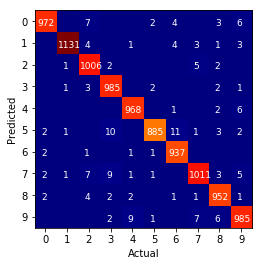

In [16]:
# evaluate the results using the test set.
# To identify mispredictions, include the raw count of each 
# (prediction, label) pair in the confusion matrix.

test_error, confusions = error_rate(test_prediction.eval(), test_labels)
print('Test error: %.1f%%' % test_error)

plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.grid(False)
plt.xticks(numpy.arange(NUM_LABELS))
plt.yticks(numpy.arange(NUM_LABELS))
plt.imshow(confusions, cmap=plt.cm.jet, interpolation='nearest');

for i, cas in enumerate(confusions):
    for j, count in enumerate(cas):
        if count > 0:
            xoff = .07 * len(str(count))
            plt.text(j-xoff, i+.2, int(count), fontsize=9, color='white')

Results are generally accurate, with some errors of predicting 3's and 6's as 5's. 

In [20]:
# code 4_mnist_from_scratch-data-dump.py
# Export the train, validation, and test objects to a binary file 
# using Python pickle dump.

import pickle  

# define collection of objects to export as binary file using pickle.
data = {
    'train_data': train_data,
    'train_labels': train_labels,
    'validation_data': validation_data,
    'validation_labels': validation_labels,
    'test_data': test_data,
    'test_labels': test_labels}

# write to binary file
with open('mnist_data.pickle', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)

print('\n Run complete. data objects sent to binary file  mnist_data.pickle')


 Run complete. data objects sent to binary file  mnist_data.pickle


In [ ]:
# shift to scikit-learn for subsequent modeling
# due to errors obtained in earlier section 
# check data for pickle dump
print('\ntrain_data object:', type(train_data), train_data.shape)    
print('\ntrain_labels object:', type(train_labels),  train_labels.shape)  
print('\nvalidation_data object:', type(validation_data),  validation_data.shape)  
print('\nvalidation_labels object:', type(validation_labels),  validation_labels.shape)  
print('\ntest_data object:', type(test_data),  test_data.shape)  
print('\ntest_labels object:', type(test_labels),  test_labels.shape)  

Ran cell, but deleted results to save space.

In [ ]:
# code from 5_mnist_from_scratch_data_load-v001.py   
# Imports the the train, validation, and test objects 
# from a binary file <mnist_data.pickle>

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function


with open('mnist_data.pickle', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    data = pickle.load(f)

# extract objects from the dictionary object data
train_data = data['train_data']
train_labels = data['train_labels'] 
validation_data = data['validation_data'] 
validation_labels = data['validation_labels'] 
test_data = data['test_data'] 
test_labels = data['test_labels']  
    
# check data from pickle load
print('\ntrain_data object:', type(train_data), train_data.shape)    
print('\ntrain_labels object:', type(train_labels),  train_labels.shape)  
print('\nvalidation_data object:', type(validation_data),  validation_data.shape)  
print('\nvalidation_labels object:', type(validation_labels),  validation_labels.shape)  
print('\ntest_data object:', type(test_data),  test_data.shape)  
print('\ntest_labels object:', type(test_labels),  test_labels.shape)  

print('\ndata input complete')

Ran cell, but deleted results to save space.

In [ ]:
# Code from mnist_from_scratch_scikit-learn-ann-v001.py
# restructure input files to use with Scikit-Learn

import numpy as np
import pandas as pd
import time

# convert binary digits to digits 0-9
def label_transform(y_in):
    for i in range(len(y_in)):
        if (y_in[i] == 1): return i

y_train = []    
for j in range(train_labels.shape[0]):
    y_train.append(label_transform(train_labels[j,]))  
y_train = np.asarray(y_train)    

y_validation = []    
for j in range(validation_labels.shape[0]):
    y_validation.append(label_transform(validation_labels[j,]))  
y_validation = np.asarray(y_validation)    

y_test = []    
for j in range(test_labels.shape[0]):
    y_test.append(label_transform(test_labels[j,]))  
y_test = np.asarray(y_test)    
    
# 28x28 matrix of entries converted to vector of 784 entries    
X_train = train_data.reshape(55000, 784)
X_validation = validation_data.reshape(5000, 784)    
X_test = test_data.reshape(10000, 784)    

# check data intended for Scikit Learn input
print('\nX_train object:', type(X_train), X_train.shape)    
print('\ny_train object:', type(y_train),  y_train.shape)  
print('\nX_validation object:', type(X_validation),  X_validation.shape)  
print('\ny_validation object:', type(y_validation),  y_validation.shape)  
print('\nX_test object:', type(X_test),  X_test.shape)  
print('\ny_test object:', type(y_test),  y_test.shape)    

In [23]:
# Scikit Learn MLP Classification does validation internally, 
# Eliminate separate validation dataset by 
# Combining the train and validation sets.

X_train_expanded = np.vstack((X_train, X_validation))
y_train_expanded = np.vstack((y_train.reshape(55000,1), y_validation.reshape(5000,1)))

print('\nX_train_expanded object:', type(X_train_expanded),  X_train_expanded.shape)  
print('\ny_train_expanded object:', type(y_train_expanded), y_train_expanded.shape)  


X_train_expanded object: <class 'numpy.ndarray'> (60000, 784)

y_train_expanded object: <class 'numpy.ndarray'> (60000, 1)


In [30]:
#run through models

RANDOM_SEED = 9999

from sklearn.neural_network import MLPClassifier

names = ['ANN-2-Layers-5-Nodes/Layer-identity',
         'ANN-2-Layers-10-Nodes/Layer-identity',
         'ANN-4-Layers-5-Nodes/Layer-identity',
         'ANN-4-Layers-10-Nodes/Layer-identity']

layers = [2, 2, 4, 4]
nodes_per_layer = [5,10,5, 10]
treatment_condition = [(5, 5), 
                       (10, 10), 
                       (5, 5, 5, 5), 
                       (10, 10, 10, 10)] 

    
methods = [MLPClassifier(hidden_layer_sizes=treatment_condition[0], activation='identity', 
              solver='adam', alpha=0.0001, batch_size='auto', 
              learning_rate='constant', learning_rate_init=0.001, 
              power_t=0.5, max_iter=500, shuffle=True, 
              random_state=RANDOM_SEED, 
              tol=0.001, verbose=False, warm_start=False, momentum=0.9, 
              nesterovs_momentum=True, early_stopping=False, 
              validation_fraction=0.083333, beta_1=0.9, beta_2=0.999, epsilon=1e-08),
    MLPClassifier(hidden_layer_sizes=treatment_condition[1], activation='identity', 
              solver='adam', alpha=0.0001, batch_size='auto', 
              learning_rate='constant', learning_rate_init=0.001, 
              power_t=0.5, max_iter=500, shuffle=True, 
              random_state=RANDOM_SEED, 
              tol=0.001, verbose=False, warm_start=False, momentum=0.9, 
              nesterovs_momentum=True, early_stopping=False, 
              validation_fraction=0.083333, beta_1=0.9, beta_2=0.999, epsilon=1e-08),
    MLPClassifier(hidden_layer_sizes=treatment_condition[2], activation='identity', 
              solver='adam', alpha=0.0001, batch_size='auto', 
              learning_rate='constant', learning_rate_init=0.001, 
              power_t=0.5, max_iter=500, shuffle=True, 
              random_state=RANDOM_SEED, 
              tol=0.001, verbose=False, warm_start=False, momentum=0.9, 
              nesterovs_momentum=True, early_stopping=False, 
              validation_fraction=0.083333, beta_1=0.9, beta_2=0.999, epsilon=1e-08),
    MLPClassifier(hidden_layer_sizes=treatment_condition[3], activation='identity', 
              solver='adam', alpha=0.0001, batch_size='auto', 
              learning_rate='constant', learning_rate_init=0.001, 
              power_t=0.5, max_iter=500, shuffle=True, 
              random_state=RANDOM_SEED, 
              tol=0.001, verbose=False, warm_start=False, momentum=0.9, 
              nesterovs_momentum=True, early_stopping=False, 
              validation_fraction=0.083333, beta_1=0.9, beta_2=0.999, epsilon=1e-08)]
 
index_for_method = 0 
training_performance_results = []
test_performance_results = []
processing_time = []
   
for name, method in zip(names, methods):
    print('\n------------------------------------')
    print('\nMethod:', name)
    print('\n  Specification of method:', method)
    start_time = time.clock()
    method.fit(X_train, y_train)
    end_time = time.clock()
    runtime = end_time - start_time  # seconds of wall-clock time 
    print("\nProcessing time (seconds): %f" % runtime)        
    processing_time.append(runtime)

    # mean accuracy of prediction in training set
    training_performance = method.score(X_train_expanded, y_train_expanded)
    print("\nTraining set accuracy: %f" % training_performance)
    training_performance_results.append(training_performance)

    # mean accuracy of prediction in test set
    test_performance = method.score(X_test, y_test)
    print("\nTest set accuracy: %f" % test_performance)
    test_performance_results.append(test_performance)
                
    index_for_method += 1  


------------------------------------

Method: ANN-2-Layers-5-Nodes/Layer-identity

  Specification of method: MLPClassifier(activation='identity', alpha=0.0001, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(5, 5), learning_rate='constant',
       learning_rate_init=0.001, max_iter=500, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=9999, shuffle=True, solver='adam', tol=0.001,
       validation_fraction=0.083333, verbose=False, warm_start=False)

Processing time (seconds): 74.480409

Training set accuracy: 0.903600

Test set accuracy: 0.900900

------------------------------------

Method: ANN-2-Layers-10-Nodes/Layer-identity

  Specification of method: MLPClassifier(activation='identity', alpha=0.0001, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(10, 10), learning_rate='constant',
       learn

In [31]:
# aggregate the results for final report
# using OrderedDict to preserve the order of variables in DataFrame    
from collections import OrderedDict  

results = pd.DataFrame(OrderedDict([('Method Name', names),
                        ('Layers', layers),
                        ('Nodes per Layer', nodes_per_layer),
                        ('Processing Time', processing_time),
                        ('Training Set Accuracy', training_performance_results),
                        ('Test Set Accuracy', test_performance_results)]))

print('\nBenchmark Experiment: Scikit Learn Artificial Neural Networks\n')
print(results)  


Benchmark Experiment: Scikit Learn Artificial Neural Networks

                            Method Name  Layers  Nodes per Layer  \
0   ANN-2-Layers-5-Nodes/Layer-identity       2                5   
1  ANN-2-Layers-10-Nodes/Layer-identity       2               10   
2   ANN-4-Layers-5-Nodes/Layer-identity       4                5   
3  ANN-4-Layers-10-Nodes/Layer-identity       4               10   

   Processing Time  Training Set Accuracy  Test Set Accuracy  
0        74.480409               0.903600             0.9009  
1        94.075236               0.928317             0.9196  
2       119.934976               0.874533             0.8685  
3        93.002103               0.927217             0.9174  


The artificial neural network structures were explored within a benchmark experiment, with two levels on each of two experimental factors.  For example, two and four layers along with five and ten nodes per layer. While many MLPClassifier models were run with different nodes, layers, solvers, iterations, etc. to fine-tune the models and adjust for bias and variance, only one result is shown in this report. For example, models with different 
activation functions for the hidden layer were run initially (relu, tanh, identity, and logistic) and the identity function showed the most promise and moved forward,

From this study, we can conclude that more work needs to be done to come up with the optimal solution. Most of the fine-tuning has been a result of trial and error, and with more time, a better solution could be found. I would recommend to the financial institution to continue to walk down the path of evaluating an artificial neural network using the MLPClassifer in Python Scikit-learn with 2 layers and 10 nodes per layer, leveraging the ‘identity’ funtion for the hidden layers along with 'adam' solver for weight optimization. A model with a similar level of accuracy, is the 4 layer, 10 nodes per layer model, suggesting that the additional layers may not be very helpful to include.

The tolerance for the optimization along with learning_rate_init should also be explored to carry out to .0001 or .00001 as when I ran these elements, the accuracy tended to improve, but the processing time lengthened. On a more powerful machine, these elements could take less time and help improve the overall model. However, the elements that I have identified appear to be trustworthy for implementing optical character recognition as both the training and test set accuracies are high.  